Extraction script for extracting data from a particular location in an HDF5 file, resampling and exporting it into a small JPEG for machine learning purposes.
--

In [112]:
# import h5py
import pandas
import h5py
from skimage.measure import block_reduce

# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter 
from pathlib import Path
import argparse  # process input arguments

# from IPython.display import display, Math, Latex
matplotlib.style.use('bmh')

%matplotlib inline
# matplotlib.style.use('seaborn-paper')

import numpy as np

# def genSciCatThumbnail(filename, dataType = 'raw', ROI = None, hdf5Location = '/entry1/processed/intermediate/'):
    
#     jpgSettings= {
#         'transparent' : True, 
#         'dpi' : 72, 
#         'optimize' : True,
#         'quality' : 70,
#     }

#     def readHDF5Value(filename, h5Path = '/entry/result/data'):
#         with h5py.File(filename, 'r') as h5f:
#             return h5f[h5Path][()]

#     def readHDF5Values(filename, pDict):
#         outDict = {}
#         dummy = [outDict.update({outKey: readHDF5Value(filename, h5Path)}) for outKey, h5Path in pDict.items()] 
#         return outDict

#     def pepperPlot(title = "plot title"):
#         # plt.legend(loc=0)
#         plt.yscale("log")
#         plt.xscale("log")
#         plt.xlabel("q (1/nm)")
#         plt.ylabel(r"I (1/(m sr))")
#         plt.title(title)

#     # datatype can be "raw" or "derived" (i.e. corrected)
#     filename = Path(filename) # just to be sure

#     if dataType == "auto":
#         if 'processed' in filename.stem:
#             dataType = "derived"
#         else:
#             dataType = "raw"

#     if dataType == "derived":
#         pDict = {'y': '/processed/result/data',
#                  'yerr': '/processed/result/errors',
#                  'x' : '/processed/result/q',
#                  'xerr': '/processed/result/q_errors'}
#     else:
#         pDict = {'y': '/entry1/instrument/detector00/data'}

#     try:
#         outDict = readHDF5Values(filename, pDict)
#     except:
#         print('could not read datasets for {} file: {}'.format(dataType, filename))
#         return None

#     # move to plotting stage:
#     try:
#         fh, (ah) = plt.subplots(1, 1, figsize = [5, 3.5])
#         plt.sca(ah)

#         if dataType == "derived":
#             # 1D datasets for processed data
#             ah = plt.errorbar(
#                 x = outDict['x'].flatten(), 
#                 y = outDict['y'].flatten(), 
#                 yerr = outDict['yerr'].flatten(), 
#                 xerr = outDict['xerr'].flatten())
#             pepperPlot("")

#         else:
#             imDat = outDict['y']
#             while imDat.ndim > 2:
#                 imDat = imDat.mean(axis = 0)
#             imDat.clip(min = imDat[imDat > 0].min())    
#             ah = plt.imshow(imDat, norm=matplotlib.colors.LogNorm())
#             formatter = LogFormatter(10, labelOnlyBase=False) 
#             plt.colorbar(format = formatter)

#         plt.tight_layout()
#         ofname = Path(filename.parent, filename.stem).as_posix() + "_thumbnail.jpg"
#         plt.savefig(ofname, **jpgSettings)
#         # also save as PDF, but not for storing in the database.
#         plt.savefig(Path(filename.parent, filename.stem).as_posix() + "_thumbnail.pdf")
#     except:
#         print('could not generate thumbnail for {} file: {}'.format(dataType, filename))
#         return None

    #return ofname # in success, ofname is output

In [108]:
jpgSettings= {
    'transparent' : True, 
    'dpi' : 72, 
    'optimize' : True,
    'quality' : 90,
}

def readHDF5Value(filename, h5Path = '/entry/result/data'):
    with h5py.File(filename, 'r') as h5f:
        if h5Path in h5f:
            return h5f[h5Path][()]
        else:
            return False

def readHDF5Values(filename, pDict):
    outDict = {}
    dummy = [outDict.update({outKey: readHDF5Value(filename, h5Path)}) for outKey, h5Path in pDict.items()] 
    return outDict


In [170]:
# datatype can be "raw" or "derived" (i.e. corrected)

# BAM/MOUSE data
# filepath = Path('Raw_datasets') # smaller subset
# hdf5Location = '/processed/intermediate/18-Remap into Q/data'
# I22 raw data:
filepath = Path('I22') # smaller subset
hdf5Location = '/entry/data/data'



for filename in filepath.glob('**/*.h5'):
    print(f'processing file {filename}')
    # read from the. HDF5 file, returns False if path does not exist in file
    im = readHDF5Value(filename, h5Path = hdf5Location)
    # if we have an image
    if isinstance(im, np.ndarray):       
        reformattedimg = im
        # reduce dimensions until we have image dimensions left. 
        while reformattedimg.ndim > 2:
            reformattedimg = reformattedimg.mean(axis = 0)

        # make sure we have positive data in our dataset. 
        reformattedimg -= reformattedimg.min()

        # debugging: do we have any nonzero data?
        print((reformattedimg>0).sum())

        # if we have any nonzero data in here
        if (reformattedimg>0).sum() > 0:
            # clip to smallest nonzero value to avoid getting nans in log10
            reformattedimg.clip(min = reformattedimg[reformattedimg > 0].min())

        # so we can see something
        reformattedimg = np.log10(reformattedimg)

        if np.isfinite(reformattedimg).sum()==0: continue # nothing we can do
        vmin = reformattedimg[np.isfinite(reformattedimg)].min() # better before reduction due to padding
        vmax = reformattedimg[np.isfinite(reformattedimg)].max()

        # for live show&tell (debugging)
        # fhs, ahs = plt.subplots(ncols = 1, nrows = 1)
        # plt.imshow(reformattedimg, cmap = plt.get_cmap('Greys_r'), vmin=vmin, vmax=vmax)
        # largest downscaling integer to get slightly larger than 256 pixels on the smallest side
        imLenMin = np.min(reformattedimg.shape)
        reductionFactor = int(np.floor(imLenMin/256))
        if reductionFactor < 1: reductionFactor = 1
        if reductionFactor > 1:
            reformattedimg = block_reduce(reformattedimg, block_size=(reductionFactor, reductionFactor), func=np.mean, cval = vmin)
            
        # save only if we have something to show. Vmin/Vmax should be on the finite values
        if (np.isfinite(reformattedimg).sum())>0:
            plt.imsave(
                f'{filename.stem}.jpg', 
                reformattedimg, 
                cmap = plt.get_cmap('Greys_r'), 
                vmin = reformattedimg[np.isfinite(reformattedimg)].min(), 
                vmax = reformattedimg[np.isfinite(reformattedimg)].max())


processing file I22/I22 Beamline Calibrants/i22-294964-Pilatus2M_SAXS.h5
processing file I22/I22 Beamline Calibrants/i22-294964-Pilatus2M_WAXS.h5
processing file I22/I22 Beamline Calibrants/i22-363051-Pilatus2M_SAXS.h5
2474931


<ipython-input-170-41910f4f8fbc>:33: RuntimeWarning: divide by zero encountered in log10
  reformattedimg = np.log10(reformattedimg)


processing file I22/I22 Beamline Calibrants/i22-363051-Pilatus2M_WAXS.h5
2191506
processing file I22/I22 Beamline Calibrants/i22-363058-Pilatus2M_SAXS.h5
2474931
processing file I22/I22 Beamline Calibrants/i22-363058-Pilatus2M_WAXS.h5
2191506
processing file I22/I22 Beamline Calibrants/i22-363061-Pilatus2M_SAXS.h5
2474931
processing file I22/I22 Beamline Calibrants/i22-363061-Pilatus2M_WAXS.h5
2191506
processing file I22/I22 Monoolein Tutorial/i22-363079-Pilatus2M_SAXS.h5
2474931
processing file I22/I22 Monoolein Tutorial/i22-363079-Pilatus2M_WAXS.h5
2191506
processing file I22/I22 Monoolein Tutorial/i22-363080-Pilatus2M_SAXS.h5
2474931
processing file I22/I22 Monoolein Tutorial/i22-363080-Pilatus2M_WAXS.h5
2191506
processing file I22/I22 Monoolein Tutorial/i22-363081-Pilatus2M_SAXS.h5
2474931
processing file I22/I22 Monoolein Tutorial/i22-363081-Pilatus2M_WAXS.h5
2191506
processing file I22/I22 Monoolein Tutorial/i22-363082-Pilatus2M_SAXS.h5
2474931
processing file I22/I22 Monoolein T

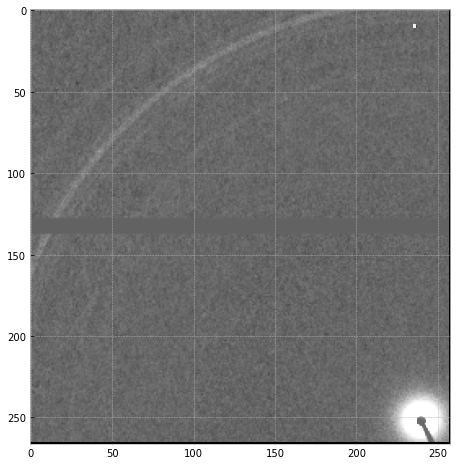

In [168]:
fh, ahs = plt.subplots(nrows = 1, ncols = 1, figsize = [10, 8])
plt.imshow(reformattedimg, vmin = vmin + 1.1, vmax = vmax - 1.2, cmap = plt.get_cmap('Greys_r'))